In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow_addons

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import tensorflow.keras.backend as K

import tensorflow_addons as tfa


In [4]:
def prepare_datasets():
    
    npzfile = np.load('/content/drive/MyDrive/fma_mfcc/shuffled_train.npz') #change path
    print(npzfile.files)
    x_train = npzfile['arr_0']
    y_train = npzfile['arr_1']
    #x_validation = x_train[2001:5000]
    #y_validation = y_train[2001:5000]
    x_train = x_train[0:1000]
    y_train = y_train[0:1000]
    print(x_train.shape, y_train.shape)

    npzfile = np.load('/content/drive/MyDrive/fma_mfcc/shuffled_valid.npz') #change path
    print(npzfile.files)
    x_validation = npzfile['arr_0']
    y_validation = npzfile['arr_1']
    
    print(x_validation.shape, y_validation.shape)



    #x_train = x_train[... , np.newaxis]
    #x_validation = x_validation[... , np.newaxis]
    #x_test = x_test[... , np.newaxis]
    return x_train, x_validation, y_train, y_validation

In [5]:
x_train, x_validation, y_train, y_validation = prepare_datasets()

['arr_0', 'arr_1']
(1000, 10, 130, 13) (1000,)
['arr_0', 'arr_1']
(799, 10, 130, 13) (799,)


In [6]:
x_test ,  y_test =  x_validation, y_validation
#x_train = x_train[... , np.newaxis]
#x_test = x_test[... , np.newaxis]
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (1000, 10, 130, 13) 74.13542604597258
Testing (799, 10, 130, 13) 71.31276365835367


In [7]:
'''
Y_train = []
Y_test = []
for i in range(y_train.shape[0]):
  index = tf.argmax(y_train[i], axis=0)
  Y_train.append(index)
y_train = np.array(Y_train)
for i in range(y_test.shape[0]):
  index = tf.argmax(y_test[i], axis=0)
  Y_test.append(index)
y_test = np.array(Y_test)
print(y_train.shape, y_test.shape)
'''
print(y_train[2]) #check values

6


In [8]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [142, 111, 139, 119, 122, 109, 129, 129]
test groups: [100, 100, 100, 100, 100, 99, 100, 100]


In [9]:
IMG_SHAPE = (10, 130, 13)
# specify the batch size and number of epochs
BATCH_SIZE = 16
EPOCHS = 50

In [10]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = layers.Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(inputs)
	x = layers.MaxPooling2D(pool_size=(2, 2), padding = 'same')(x)
	x = layers.Dropout(0.4)(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
	x = layers.MaxPooling2D(pool_size=(2,2), padding = 'same')(x)
	x = layers.Dropout(0.4)(x)
  # third set of CONV => RELU => POOL => DROPOUT layers
	x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
	x = layers.MaxPooling2D(pool_size=(2,2), padding = 'same')(x)
	x = layers.Dropout(0.4)(x)
  # fourth set of CONV => RELU => POOL => DROPOUT layers
	x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
	x = layers.MaxPooling2D(pool_size=(2,2), padding = 'same')(x)
	x = layers.Dropout(0.4)(x)
 	# prepare the final outputs
	x = layers.Flatten()(x)
	#pooledOutput = layers.GlobalAveragePooling2D()(x)
	outputs = layers.Dense(embeddingDim)(x)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [11]:
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [12]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))



In [13]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

In [14]:
print("preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(x_train, y_train)
(pairTest, labelTest) = make_pairs(x_test, y_test)

preparing positive and negative pairs...


In [15]:
print("building siamese network...")
imgA = layers.Input(shape=IMG_SHAPE)
imgB = layers.Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
featureExtractor.summary()

building siamese network...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 130, 13)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 130, 256)      30208     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 65, 256)        0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 65, 256)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 65, 256)        590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 33, 256)        0         
_________________________________________________________________
dropout_1 (Dropout)          (Non

In [16]:
#distance = layers.Lambda(euclidean_distance)([featsA, featsB])
combined = layers.concatenate([featsA, featsB])
combined = layers.Dense(64, activation = 'relu')(combined)
combined = layers.BatchNormalization()(combined)
combined = layers.Dense(32, activation = 'relu')(combined)
combined = layers.BatchNormalization()(combined)
combined = layers.Dense(16, activation = 'relu')(combined)
combined = layers.BatchNormalization()(combined)
outputs = layers.Dense(1, activation="sigmoid")(combined)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [17]:
import gc

del x_train
del x_test
del y_train
del y_test
gc.collect()

1648

In [18]:

#model.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer='adam',metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# train the model
print("training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS, shuffle = True)

training model...
Epoch 1/50
125/125 [==============================] - 4s 18ms/step - loss: 0.7758 - accuracy: 0.5135 - val_loss: 0.7263 - val_accuracy: 0.4887
Epoch 2/50
125/125 [==============================] - 2s 15ms/step - loss: 0.7314 - accuracy: 0.5035 - val_loss: 0.8634 - val_accuracy: 0.5150
Epoch 3/50
125/125 [==============================] - 2s 14ms/step - loss: 0.7094 - accuracy: 0.5065 - val_loss: 0.7685 - val_accuracy: 0.5332
Epoch 4/50
125/125 [==============================] - 2s 14ms/step - loss: 0.6949 - accuracy: 0.5330 - val_loss: 0.6853 - val_accuracy: 0.5651
Epoch 5/50
125/125 [==============================] - 2s 14ms/step - loss: 0.6910 - accuracy: 0.5345 - val_loss: 0.6831 - val_accuracy: 0.5569
Epoch 6/50
125/125 [==============================] - 2s 14ms/step - loss: 0.6900 - accuracy: 0.5325 - val_loss: 0.6900 - val_accuracy: 0.5401
Epoch 7/50
125/125 [==============================] - 2s 14ms/step - loss: 0.6877 - accuracy: 0.5360 - val_loss: 0.6780 - va

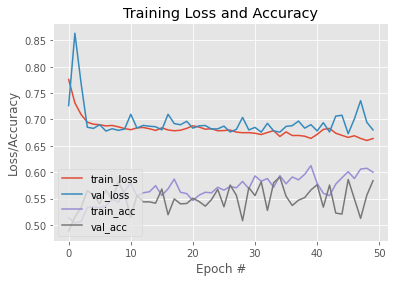

In [19]:
plot_training(history)